In [7]:
from rag_module.rag import RAG
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import mlflow

c:\Users\SjoerdO\AppData\Local\pypoetry\Cache\virtualenvs\rag--7y4UdRY-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# -- Not in use --

class explainaRAG(RAG):
    """
    This class extends the RAG class with explanation methods.
    """

    def __init__(self, *args, **kwargs):
        """
        Initializes the explainaRAG instance with the provided arguments.
        """
        super().__init__(*args, **kwargs)
        self.scope_model_id = '5217cda942f54213aeb8d18a8dcdaa79'
        self.scope_model = None
        self.load_scope_model()

    def load_scope_model(self):
        # Construct the model URI
        model_uri = f"runs:/{self.scope_model_id}/model"

        # Load the model
        try:
            model = mlflow.sklearn.load_model(model_uri)
            print(f"Successfully loaded model from run {self.scope_model_id}")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

        self.scope_model = model

    def is_in_scope(self, query, threshold=0.5):
        n_chunks = self.embedder.index.ntotal
        n_dims = self.embedder.dim
        
        document_vectors = np.zeros((n_chunks, n_dims), dtype=np.float32)
        for i in range(n_chunks):
            document_vectors[i] = self.embedder.index.reconstruct(i)
        query_vector = self.embedder.encode(query).reshape(1, -1)
        similarities = cosine_similarity(query_vector, document_vectors)
        
        max_sim = np.max(similarities)  # Highest similarity score
        if max_sim > threshold:
            return True, max_sim
        else:
            return False, max_sim
        

In [ ]:
# -- Not in use --

run_id = '5217cda942f54213aeb8d18a8dcdaa79'

# Construct the model URI
model_uri = f"runs:/{run_id}/model"

# Load the model
try:
    model = mlflow.sklearn.load_model(model_uri)
    print(f"Successfully loaded model from run {run_id}")
except Exception as e:
    print(f"Error loading model: {e}")
    raise


Successfully loaded model from run 5217cda942f54213aeb8d18a8dcdaa79


## In/Out scope
**Experiment**: See if the distance between query and database documents can be visualized. <br>
**Conclusion**: It cannot be visualized, as dimensionality reduction can make it seem as if points are close, when they are not.

In [3]:
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load FAISS index
faiss_index_path = "./embeddings/guidance_framework_2/chunk_vectors.faiss"
index = faiss.read_index(faiss_index_path)

# Get stored document vectors
num_docs = index.ntotal
d = index.d  # Vector dimension
document_vectors = np.zeros((num_docs, d), dtype=np.float32)
for i in range(num_docs):
    document_vectors[i] = index.reconstruct(i)

# Load embedding model (use the same one used to create FAISS index)
model = SentenceTransformer("all-MiniLM-L6-v2")

# Embed user query
query_text = "explainability in RAG systems."
query_vector = model.encode(query_text).astype(np.float32).reshape(1, -1)

# Search in FAISS (find nearest neighbors)
k = 5  # Number of nearest neighbors to retrieve
distances, indices = index.search(query_vector, k)

# Compute cosine similarity
similarities = cosine_similarity(query_vector, document_vectors)
max_sim = np.max(similarities)  # Highest similarity score
threshold = 0.5  # Define a threshold for "in scope"

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(np.vstack([document_vectors, query_vector]))

# Split transformed vectors
docs_2d = reduced_vectors[:-1]  # Document embeddings
query_2d = reduced_vectors[-1]   # Query embedding

# Plot document space
#plt.scatter(docs_2d[:, 0], docs_2d[:, 1], label="Documents", alpha=0.5, s=5)
#plt.scatter(query_2d[0], query_2d[1], color='orange', label="User Query", s=20)

# # Mark if query is out-of-scope
# color = "green" if max_sim > threshold else "red"
# plt.text(query_2d[0], query_2d[1], "OUT-OF-SCOPE" if max_sim < threshold else "IN-SCOPE", 
#          color=color, fontsize=12, ha='right')

#plt.xlabel("Component 1")
#plt.ylabel("Component 2")
#plt.title("RAG Feature Space - Query vs Database")
#plt.legend()
#plt.show()

# Print results
if max_sim > threshold:
    print(f"✅ Query: {query_text}\n is IN-SCOPE (Max similarity: {max_sim:.2f})")
else:
    print(f"❌ Query: {query_text}\n is OUT-OF-SCOPE (Max similarity: {max_sim:.2f})")


❌ Query: explainability in RAG systems.
 is OUT-OF-SCOPE (Max similarity: 0.33)


## EMD
**Experiment**: See if Earth Moving Distance is useful

In [3]:
# Earth Moving Distance (EMD) calculation
from scipy.stats import wasserstein_distance

rag = RAG()

Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...


In [ ]:
query = "What is the role of a scrum master?"

n_chunks = rag.embedder.index.ntotal
n_dims = rag.embedder.dim

document_vectors = np.zeros((n_chunks, n_dims), dtype=np.float32)
for i in range(n_chunks):
    document_vectors[i] = rag.embedder.index.reconstruct(i)
query_vector = rag.embedder.encode(query).reshape(1, -1)



Batches: 100%|██████████| 1/1 [00:00<00:00, 55.90it/s]


In [19]:
EMD_distances = [wasserstein_distance(query_vector.flatten(), doc.flatten()) for doc in document_vectors]

In [22]:
# get max EMD distance
max_EMD = np.max(EMD_distances)  # Highest EMD distance

# max index
max_index = np.argmax(EMD_distances)  # Index of the document with the highest EMD distance


In [23]:
max_EMD_doc = document_vectors[max_index]

In [26]:
rag.print_chunk(max_index)  # Print the chunk with the highest EMD distance

"Laser. Laser focus," said Marc Skinner, after Manchester United rounded off their pre-season campaign with a less-than-perfect 1-0 defeat to Tottenham. "We were a bit sluggish and that cannot happen," he added. 'Same but different' is the mantra for the new term, as Skinner attempts to navigate the loss of some of United's most well-known and well-respected players, while improving on last year's underwhelming fifth-place finish. Incomings have been shrewd, which will mitigate some of the fallout, but Skinner's biggest assignment this season will concern the cloud that has engulfed Carrington over the past 12 months, and how to lift it. No easy task - it's consistently overcast in Manchester. Image: Mary Earps left Man Utd in pursuit of silverware this summer, joining PSG on a free transfer

The so-called 'summer of discontent', which saw Mary Earps and Katie Zelem leave, among others, and raised issues over temporary training facilities as well as where the team ranks in the overall 

## Database description
**Experiment**: See if a description of the database can be used to determine if a query falls in the scope of the database

In [40]:
import pandas as pd

In [ ]:
description = "news articles about sports, business, politics, news, travel, entertainment and science"

In [41]:
# load data
silver = pd.read_csv("eval_data/ScopeQA/ELOQ_silver.csv")
gold = pd.read_csv("eval_data/ScopeQA/ELOQ_gold.csv")

In [51]:
gold['cat'] = gold['doc_id'].apply(lambda x: x.split("_")[0])

In [53]:
gold['vector'] = gold['question'].apply(lambda x: rag.embedder.encode(x).reshape(1, -1))

Batches: 100%|██████████| 1/1 [00:00<00:00, 87.98it/s]


In [57]:
database_general_vector = rag.embedder.encode(description).reshape(1, -1)
gold['similarity'] = gold['vector'].apply(lambda x: cosine_similarity(x, database_general_vector).flatten()[0])

Batches: 100%|██████████| 1/1 [00:00<00:00, 69.37it/s]


<Axes: ylabel='cat'>

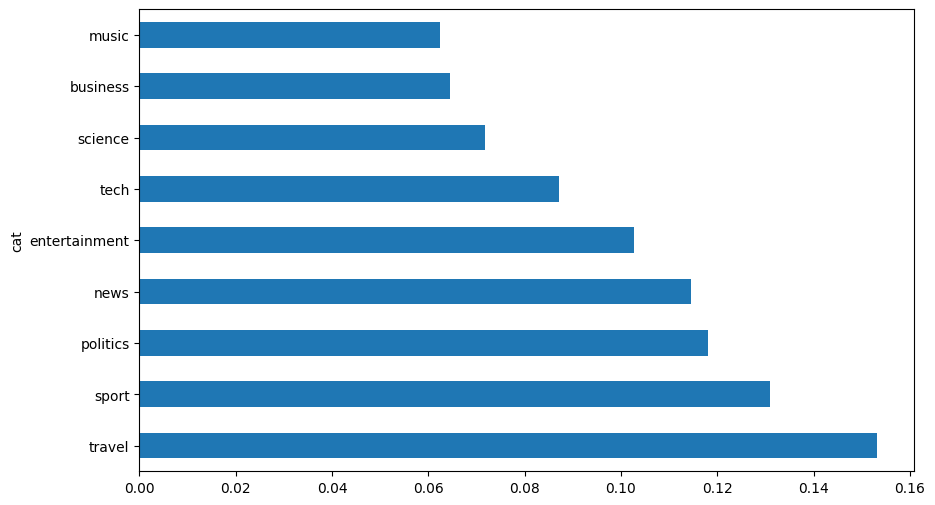

In [59]:
gold.groupby('cat')['similarity'].mean().sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))

## NLI
**Experiment**: See if a Natural Language Inference model can be used to determine if a query falls in the scope of the database based on a description of the database. <br>
**Conclusion**: NLI model often outputs contradiction, when entailment is expected.

In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load the model and tokenizer
model_name = "roberta-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def predict_entailment(premise, hypothesis):
    """
    Predict whether the premisse (description) entails the hypothesis (query)
    
    Args:
        premisse (str): The variable description (e.g., "a person's age in years")
        hypothesis (str): The variable query (e.g., "age of the individual")
    
    Returns:
        dict: Containing the predicted label and probabilities for each class
    """
    # Tokenize the input
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get probabilities
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Get the predicted label
    predicted_label_id = torch.argmax(probabilities, dim=-1).item()
    label_map = {0: "contradiction", 1: "neutral", 2: "entailment"}
    predicted_label = label_map[predicted_label_id]
    
    return {
        "label": predicted_label,
        "probabilities": {
            "contradiction": round(probabilities[0][0].item(), 4),
            "neutral": round(probabilities[0][1].item(), 4),
            "entailment": round(probabilities[0][2].item(), 4)
        }
    }

# Example usage
var_description = "a question about software engineering practices."
var_query = "What is a SQL database?"

result = predict_entailment(var_description, var_query)
print(f"Prediction: {result['label']}")
print(f"Probabilities: {result['probabilities']}")





Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Prediction: contradiction
Probabilities: {'contradiction': 0.8013, 'neutral': 0.1705, 'entailment': 0.0282}


## Goodness of Fit
**Experiment**: See if scope detection can be done using Goodness of Fit. This is a statistical test to see if a query falls in the distribution of queries that are in the scope of the database. Different test statistics can be used, such as Maximum Similarity Score in dense or sparse embedding.

In [ ]:
#df = pd.read_csv("eval_data/SyntheticQA/QA_sets/250318173604.csv")
df = pd.read_csv("eval_data/SyntheticQA/QA_sets/250418173604.csv")

In [ ]:
# load all dfs in eval_data/SyntheticQA/QA_sets/
import os
import pandas as pd

# Get all CSV files in the directory
directory = "eval_data/SyntheticQA/QA_sets/"
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Loop through the files and read them into DataFrames
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all DataFrames into one
df_gf = pd.concat(dataframes, ignore_index=True)
df_gf = df.groupby('chunk_id').first()

print(f'n queries guidance framework: {len(df_gf)}')

In [4]:
silver = pd.read_csv("eval_data/ScopeQA/ELOQ_silver.csv")
gold = pd.read_csv("eval_data/ScopeQA/ELOQ_gold.csv")

In [5]:
os.environ["embedding_path"] = "./embeddings/guidance_framework_2/"

In [8]:
# set RAG models
rag = RAG(reranker_name="flashrank", retrieve_top_k=10)

Loading default flashrank model for language en
Default Model: ms-marco-MiniLM-L-12-v2
Loading FlashRankRanker model ms-marco-MiniLM-L-12-v2 (this message can be suppressed by setting verbose=0)
Loading model FlashRank model ms-marco-MiniLM-L-12-v2...


In [9]:
def closest_chunk_scores(rag, df):
    "add scores for the closest chunk to each question"
    # check if column already exists
    if not 'top_sparse_score' in df.columns:
        df['top_sparse_score'] = df['question'].apply(lambda q: rag.embedder.search_bm25(q, top_k=1)[0][0])

    if not 'top_dense_score' in df.columns:
        df['top_dense_score'] = df['question'].apply(lambda q: rag.embedder.search(q, top_k=1)[0][0][0])

    # if not 'top_reranker_score' in df.columns:
    #     top_ranked = df['question'].apply(lambda q: rag.retrieve(q)[0])
    #     df['top_reranker_doc'] = top_ranked.apply(lambda x: x['filename'])
    #     df['top_reranker_score'] = top_ranked.apply(lambda x: x['score'])

In [ ]:
closest_chunk_scores(rag, silver)

KeyboardInterrupt: 

: 

In [ ]:
closest_chunk_scores(rag, df_gf)
closest_chunk_scores(rag, gold)

Batches: 100%|██████████| 1/1 [00:00<00:00, 25.70it/s]


In [27]:
from rag_module.rag import Embedder

# add labels to eval data
embedder = Embedder(model_name="all-MiniLM-L6-v2")
database_filenames = set(chunk['filename'] for chunk in embedder.chunkdata)

def add_labels(df, database_filenames):
    """
    Add 'in_database' and 'label' columns to the dataframe.
    - 'in_database': whether the document appears in the known database filenames.
    - 'label':
        - 0: query relates to a document in the database and is answerable
        - 1: query relates to a document in the database but is not answerable
        - 2: query relates to a document not in the database
    """
    df['in_database'] = df['doc_id'].isin(database_filenames)
    
    df['label'] = 2
    df.loc[df['in_database'] & (df['llm_confusion_label'] == 'no'), 'label'] = 0
    df.loc[df['in_database'] & (df['llm_confusion_label'] == 'yes'), 'label'] = 1

add_labels(gold, database_filenames)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [52]:
add_labels(silver, database_filenames)

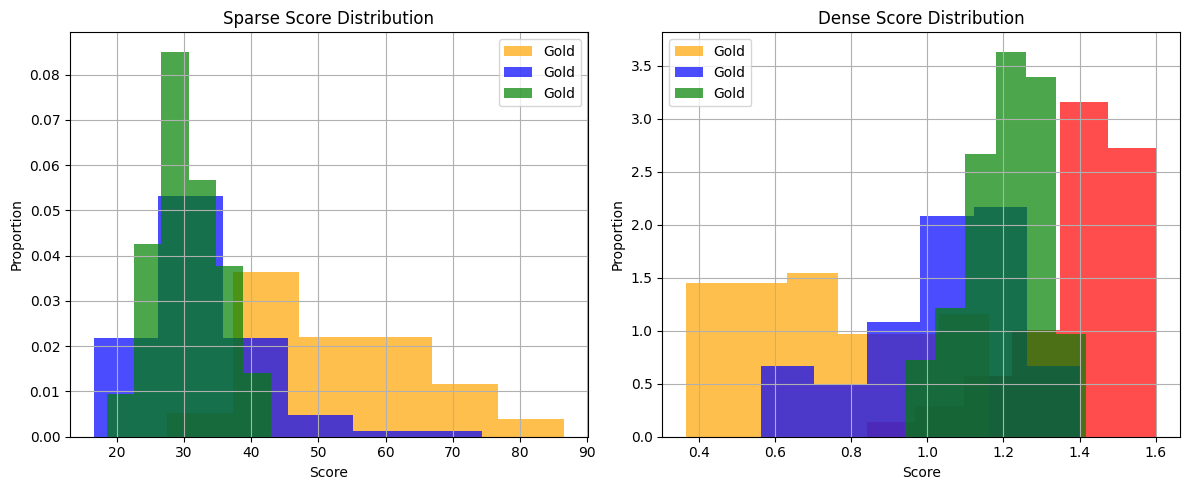

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side (independent y-axes)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

def plot_distribution(df, column, ax, color, label):
    """
    Plot the distribution of a given column in the dataframe.
    """
    for label in df['label'].unique():
        subset = df[df['label'] == label]
        if not subset.empty:
            subset[column].hist(bins=6, alpha=0.7, color=color, ax=ax, label=label, density=True)
    ax.legend()
    ax.set_title(f'{column} Distribution') 
    ax.set_xlabel('Score')
    ax.set_ylabel('Proportion')  # Because we're plotting densities

plot_distribution(silver, 'top_sparse_score', axs[0], 'blue', 'Sparse Score')
plot_distribution(silver, 'top_dense_score', axs[1], 'red', 'Dense Score')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def compute_z_score_and_p_value(value, mean, std, onetailed=True):
    """Compute the z-score and p-value for a given value."""
    if std == 0:
        raise ValueError("Standard deviation is zero. Cannot compute z-score.")

    z = (value - mean) / std
    if onetailed:
        p = 1 - norm.cdf(z)
    else:
        p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

def apply_z_test_to_dataframe(df, reference_series, column, onetailed=True, alpha=0.1):
    """Apply z-test to a DataFrame column against a reference distribution."""
    mean = reference_series.mean()
    std = reference_series.std(ddof=1)

    if std == 0:
        raise ValueError("Standard deviation is zero. Cannot compute z-scores.")

    results = df[column].apply(lambda x: compute_z_score_and_p_value(x, mean, std, onetailed))
    df['z_score'] = results.apply(lambda x: x[0])
    df['p_value'] = results.apply(lambda x: x[1])
    df['OOS'] = df['p_value'] < alpha
    return df

In [ ]:
# Assuming df_gf is your reference and gold is your target
gold = apply_z_test_to_dataframe(gold, df_gf['top_dense_score'], column='top_dense_score')

In [47]:
gold['OOS'].value_counts()

OOS
False    216
Name: count, dtype: int64

In [50]:
df_gf['OOS'].value_counts()

OOS
False    53
True      2
Name: count, dtype: int64

In [48]:
gold[gold['label'] == 2]

,doc_id,q_id,llm_confusion_label,human_confusion_label,llm_defusion_label,human_defusion_label,question,answer,top_sparse_score,top_dense_score,in_database,label,z_score,p_value,OOS
43,music_189,music_189_1_1,yes,yes,no,no,How did DJ Mehdi's innovative approach to musi...,"DJ Mehdi's innovative approach to music, parti...",28.298436,1.320123,False,2,-0.423797,0.664143,False
44,music_189,music_189_0_2,no,yes,NaN,no,"How does the series ""DJ Mehdi: Made in France""...","The series ""DJ Mehdi: Made in France"" utilizes...",32.841966,1.290070,False,2,-0.623980,0.733679,False
45,music_189,music_189_1_6,yes,yes,no,no,How did the archival footage in the documentar...,The archival footage in the documentary depict...,33.341519,1.282706,False,2,-0.673029,0.749536,False
46,music_189,music_189_1_2,yes,yes,no,no,In what ways did DJ Mehdi's distinctive sound ...,DJ Mehdi redefined the boundaries of electroni...,28.827294,1.380558,False,2,-0.021238,0.508472,False
47,music_189,music_189_1_5,yes,yes,yes,yes,What particular awards did DJ Mehdi receive th...,DJ Mehdi did not receive any particular awards...,23.765510,1.321802,False,2,-0.412615,0.660056,False
48,music_189,music_189_0_4,no,no,NaN,NaN,What tragic event led to the premature end of ...,DJ Mehdi's life and career came to a premature...,30.238743,1.252335,False,2,-0.875332,0.809303,False
52,tech_85,tech_85_0_1,no,no,NaN,NaN,How has the success of a specific film influen...,The success of the film CODA winning the Best ...,42.935009,1.107412,False,2,-1.840658,0.967164,False
53,tech_85,tech_85_1_1,yes,no,no,NaN,How did Apple Inc. decide on the subscription ...,Apple Inc. decided on the subscription model f...,33.946889,0.941425,False,2,-2.946292,0.998392,False
54,tech_85,tech_85_1_4,yes,yes,no,no,What influences the duration of the free trial...,The duration of the free trial period offered ...,32.366223,1.157890,False,2,-1.504427,0.933764,False
55,tech_85,tech_85_1_2,yes,yes,no,no,What strategies did Apple employ to launch App...,Apple employed various strategies to launch Ap...,29.213659,0.979066,False,2,-2.695568,0.996487,False


In [49]:
gold['label'].value_counts()

label
1    86
0    78
2    52
Name: count, dtype: int64